## **Section 4.1: Effect of Resource Type on Achieved Lookup Rate**

- With this experiment, we determined the effect that the embedded subresource type (`jpg`, `css`, `font`, `script` (called `js` below), `iframe`, and `fetch`) has on the achieved `HS_DESC` lookup rate.
- Before this experiment, we had fixed `60 seconds` as the attack duration.
- The data was collected on a desktop machine at our university.
- We ran the attack script `3` times per each of the `2` onion versions per each of the `6` resource types per each of the `7` injection rates (`1`, `2`, `3`, `4`, `5`, `7`, and `10`) we were still evaluating at this point.
- We thus expect to have `3 * 2 * 6 * 7 = 252` result folders.

In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob
from os.path import abspath, dirname, join, basename, isfile

In [2]:
DATA_DIR = abspath("./1_data_resource-type")
EXPERIMENT_PARAMS_JSON = "experiment.json"

In [3]:
def load_from_json(json_path):
    return json.loads(open(json_path).read())

In [4]:
! ls $DATA_DIR | grep gacar-lnx-desktop | grep per-sec-over-60-sec | wc -l         # Should yield: 252
! ls $DATA_DIR | grep gacar-lnx-desktop | grep jpg-per-sec-over-60-sec | wc -l     # Should yield: 42
! ls $DATA_DIR | grep gacar-lnx-desktop | grep css-per-sec-over-60-sec | wc -l     # Should yield: 42
! ls $DATA_DIR | grep gacar-lnx-desktop | grep font-per-sec-over-60-sec | wc -l    # Should yield: 42
! ls $DATA_DIR | grep gacar-lnx-desktop | grep js-per-sec-over-60-sec | wc -l      # Should yield: 42
! ls $DATA_DIR | grep gacar-lnx-desktop | grep iframe-per-sec-over-60-sec | wc -l  # Should yield: 42
! ls $DATA_DIR | grep gacar-lnx-desktop | grep fetch-per-sec-over-60-sec | wc -l   # Should yield: 42

252
42
42
42
42
42
42


#### How many victim lookups (`HS_DESC` lookups with `404 Not Found` response) did we see?

- The following should yield: `242,004`.

In [5]:
%%bash
{ grep -r "hsdesc_notfound_cnt" ./1_data_resource-type/*gacar-lnx-desktop*per-sec-over-60-sec | tr -s " " | cut -d " " -f 3 | tr -s ",\n" "+"; printf "0\n"; } | bc

242004


In [6]:
result_tuples = []

# Read in all result.json and experiment.json files.
for results_json in glob(join(DATA_DIR, "*gacar-lnx-desktop*per-sec-over-60-sec", "results.json")):
    
    exp_json = join(dirname(results_json), EXPERIMENT_PARAMS_JSON)
    if not isfile(exp_json):
        continue

    exp_params = load_from_json(exp_json)
    results = load_from_json(results_json)
    results.update(exp_params)
    result_tuples.append(results)

# Create the dataframe from the list of dicts.
df = pd.DataFrame.from_records(result_tuples)

In [7]:
print(len(df))
df.head(15)

252


,run_time_sec,circ_built_per_sec,hsdesc_notfound_per_sec,circ_cnt,circ_built_cnt,circ_failed_cnt,circ_undetermined_cnt,hsdesc_cnt,hsdesc_recvd_cnt,hsdesc_notfound_cnt,...,log_level,num_parallel,auto_start,onion_ver,resource_type,rate_per_sec,circuit_log_interval,buffer_time,excluded_circ_purposes,additional_torrc_params
0,60.165,5.717610,5.534779,367,344,21,2,339,0,333,...,20,1,true,2,jpg,1,1,10,[GENERAL],{}
1,60.275,5.873082,5.541269,379,354,21,4,342,1,334,...,20,1,true,2,jpg,1,1,10,[GENERAL],{}
2,60.301,5.771049,5.671548,366,348,14,4,348,1,342,...,20,1,true,2,jpg,1,1,10,[GENERAL],{}
3,60.110,5.872567,5.672933,377,353,21,3,347,0,341,...,20,1,true,3,jpg,1,1,10,[GENERAL],{}
4,59.433,5.720728,5.653425,363,340,17,6,343,1,336,...,20,1,true,3,jpg,1,1,10,[GENERAL],{}
5,59.549,5.726377,5.508069,368,341,22,5,340,1,328,...,20,1,true,3,jpg,1,1,10,[GENERAL],{}
6,59.757,11.697374,11.312482,753,699,48,6,691,1,676,...,20,1,true,2,jpg,2,1,10,[GENERAL],{}
7,59.542,11.622048,11.336536,723,692,26,5,687,0,675,...,20,1,true,2,jpg,2,1,10,[GENERAL],{}
8,60.073,11.436086,11.319561,726,687,33,6,690,0,680,...,20,1,true,2,jpg,2,1,10,[GENERAL],{}
9,59.802,11.554797,11.337413,743,691,44,8,689,0,678,...,20,1,true,3,jpg,2,1,10,[GENERAL],{}


In [8]:
# Ensure that no measurement sees more HS_DESC lookups per second
# than it sees built circuits per second.
for _, row in df.iterrows():

    assert not (row["circ_built_per_sec"] < row["hsdesc_notfound_per_sec"])
    
    if row["circ_built_per_sec"] == row["hsdesc_notfound_per_sec"]:
        print("We have a row in which CIRC_BUILT_PER_SEC={} equals HSDESC_NOTFOUND_PER_SEC={}".format(
            row["circ_built_per_sec"], row["hsdesc_notfound_per_sec"]))

### `HSDESC_NOTFOUND_PER_SEC` for Onion Version 2

<AxesSubplot:xlabel='rate_per_sec', ylabel='hsdesc_notfound_per_sec'>

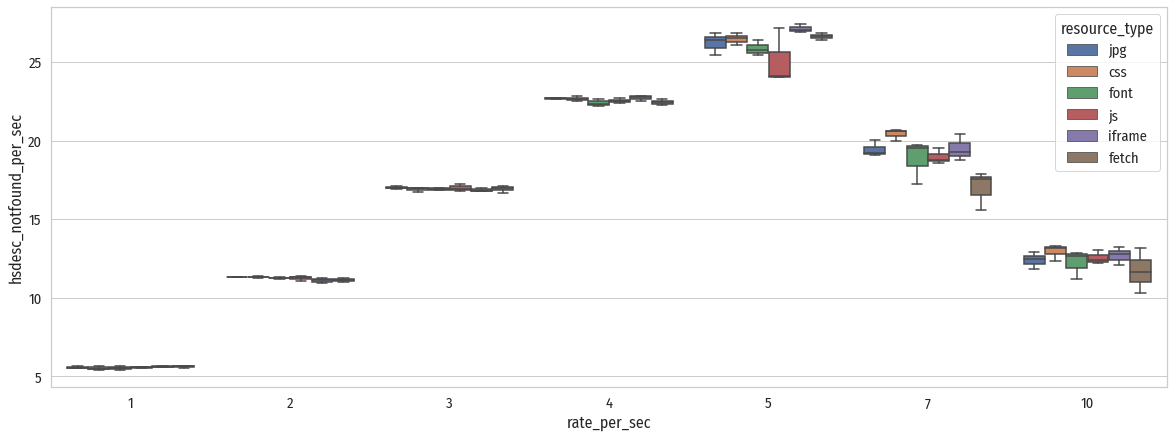

In [9]:
plt.figure(figsize=(20, 7))

sns.set()
sns.set(style="whitegrid", font_scale=1.33)
sns.set_style({"font.family": "Fira Sans Condensed"})

sns.boxplot(x="rate_per_sec", y="hsdesc_notfound_per_sec", hue="resource_type", data=df[df.onion_ver==2])

### `HSDESC_NOTFOUND_PER_SEC` for Onion Version 3

<AxesSubplot:xlabel='rate_per_sec', ylabel='hsdesc_notfound_per_sec'>

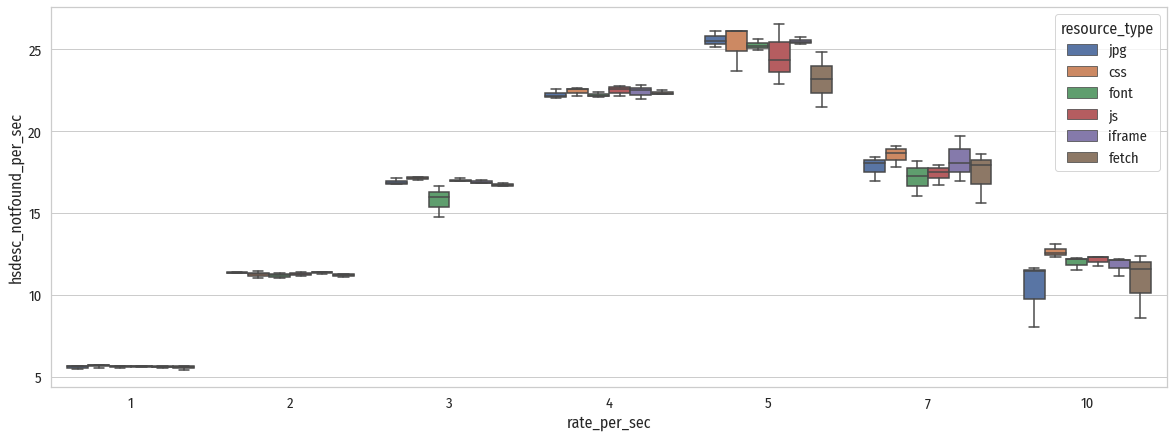

In [10]:
plt.figure(figsize=(20, 7))

sns.set()
sns.set(style="whitegrid", font_scale=1.33)
sns.set_style({"font.family": "Fira Sans Condensed"})

sns.boxplot(x="rate_per_sec", y="hsdesc_notfound_per_sec", hue="resource_type", data=df[df.onion_ver==3])

### Median `HSDESC_NOTFOUND_PER_SEC` for Onion Version 2, grouped by `rate_per_sec` and `resource_type`

In [11]:
df[df.onion_ver==2].groupby(["rate_per_sec", "resource_type"]).hsdesc_notfound_per_sec.median()

rate_per_sec  resource_type
1             css               5.496260
              fetch             5.645446
              font              5.560937
              iframe            5.632720
              jpg               5.541269
              js                5.609586
2             css              11.307586
              fetch            11.106458
              font             11.267091
              iframe           11.103886
              jpg              11.319561
              js               11.316010
3             css              16.999967
              fetch            16.987148
              font             16.923951
              iframe           16.818885
              jpg              16.987051
              js               16.944080
4             css              22.630338
              fetch            22.436594
              font             22.332878
              iframe           22.795411
              jpg              22.693446
              js             

### Median `HSDESC_NOTFOUND_PER_SEC` for Onion Version 3, grouped by `rate_per_sec` and `resource_type`

In [12]:
df[df.onion_ver==3].groupby(["rate_per_sec", "resource_type"]).hsdesc_notfound_per_sec.median()

rate_per_sec  resource_type
1             css               5.736297
              fetch             5.620711
              font              5.661194
              iframe            5.615831
              jpg               5.653425
              js                5.649812
2             css              11.261149
              fetch            11.206637
              font             11.202327
              iframe           11.407036
              jpg              11.353741
              js               11.268213
3             css              17.149754
              fetch            16.735012
              font             15.964685
              iframe           16.864947
              jpg              16.816218
              js               16.972064
4             css              22.564256
              fetch            22.272418
              font             22.168554
              iframe           22.498450
              jpg              22.129714
              js             